In [87]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import platform
import tkinter as tk
from tkinter import filedialog

from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.plotting.spikes import plot_raster
from neuropy.plotting.signals import plot_signal_w_epochs

sys.path.insert(1, 'C:/BrianKim/Code/Repositories/cnn-ripple/src/cnn/')

In [88]:
# Define a class for a typical recording or set of recordings
class ProcessData:
    def __init__(self, basepath):
        basepath = Path(basepath)
        self.basepath = basepath
        xml_files = sorted(basepath.glob("*.xml"))
        assert len(xml_files) == 1, "Found more/less than one .xml file"
        
        fp = xml_files[0].with_suffix("")
        self.filePrefix = fp
        
        self.recinfo = NeuroscopeIO(xml_files[0])
        eegfiles = sorted(basepath.glob('*.eeg'))
        assert len(eegfiles) == 1, "Fewer/more than one .eeg file detected"
        self.eegfile = BinarysignalIO(eegfiles[0], n_channels=self.recinfo.n_channels,
                                     sampling_rate=self.recinfo.eeg_sampling_rate,
                                     )
        try:
            self.datfile = BinarysignalIO(eegfiles[0].with_suffix('.dat'),
                                         n_channels=self.recinfo.n_channels,
                                         sampling_rate=self.recinfo.dat_sampling_rate,
                                         )
        except FileNotFoundError:
            print('No dat file found, not loading')
                
        
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.recinfo.source_file.name})"
    
def sess_use(basepath=os.getcwd()):
    """Load in data. Uses current directory as default"""

    return ProcessData(basepath)

In [90]:
# Open a directory chooser dialog
dir_use = filedialog.askdirectory(title="Please select a data folder")

# Check if user selected a directory or pressed cancel
if dir_use:
    print(f"Selected Data Directory: {dir_use}")
else:
    print("No directory was selected.")

sess = sess_use(dir_use)

print(sess.recinfo)
print(sess.eegfile)

Selected Data Directory: D:/Data/RippleDetection/20230309Recall1
No dat file found, not loading
filename: D:\Data\RippleDetection\20230309Recall1\Django_recall1_denoised.xml 
# channels: 134
sampling rate: 30000
lfp Srate (downsampled): 1250

duration: 4532.47 seconds 
duration: 1.26 hours 


In [91]:
from neuropy.analyses.artifact import detect_artifact_epochs

cur_file = 'D:/Data/RippleDetection/20230309Recall1/Django_recall1_denoised.eeg'
binary_data = BinarysignalIO(cur_file, n_channels=134,sampling_rate=30000)
signal_obj = binary_data.get_signal()
whole_data = signal_obj.traces
print(np.shape(whole_data))

signal = sess.eegfile.get_signal()
buffer_add = 0.1  # seconds, None = don't add


art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=6, 
                                    edge_cutoff=1, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')  # Write to neuroscope
    art_epochs.save(art_epochs_file)
art_epochs


(134, 5665590)
Buffer of 0.1 added before/after each epoch
D:\Data\RippleDetection\20230309Recall1\Django_recall1_denoised.art_epochs.npy saved


50 epochs
Snippet: 
       start      stop label
0   15.8128   16.0408      
1  146.7296  147.0024      
2  270.5160  270.7768      
3  410.8512  411.0968      
4  421.0152  421.3176      

In [92]:
# Remove Aux channels
# Currently only using the first 8 channels as a proof of concept
data = np.copy(whole_data[54:62,:])
data = data.T

In [93]:
# Z-score normalization
channels = range(np.shape(data)[1])
zscored_data = np.empty(np.shape(data))
for channel in channels:
    dmax = np.amax(data[:, channel])
    dmin = abs(np.amin(data[:, channel]))
    dabs = dmax if dmax>dmin else dmin
    
    m = np.mean(data[:, channel] / dmax) * dmax
    s = np.std(data[:, channel] / dmax) * dmax
    s = 1 if s == 0 else s
    zscored_data[:, channel] = ((data[:, channel] - m) / s).astype('float16')

In [94]:
overlapping = True
window_size = 0.0128
print("Generating Windows...", end=" ")
if overlapping:
    from load_data import generate_overlapping_windows
    
    stride = 0.0064
    
    # Separate the data into 12.8ms windows with 6.4ms overlapping
    X = generate_overlapping_windows(zscored_data, window_size, stride, 1250)
else:
    stride = window_size
    X = np.expand_dims(zscored_data, 0)
print("Done!")

Generating Windows... Done!


In [95]:
import tensorflow.keras.backend as K
import tensorflow.keras as kr

print("Loading CNN model...", end=" ")
model_path = r'C:\BrianKim\Code\Repositories\cnn-ripple\model'

optimizer = kr.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
model = kr.models.load_model(model_path, compile=False)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

print("Done!")

Loading CNN model... WARNING:tensorflow:SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.


Done!


In [96]:
print("Detecting ripples...", end=" ")
predictions = model.predict(X, verbose=True)
print("Done!")

22132/22132 [==============================] - 20s 900us/step
Done!


In [83]:
from format_predictions import get_predictions_indexes

# Tweak this threshold based on specific needs
threshold = 0.7

print("Getting detected ripples indexes and times...", end=" ")
pred_indexes = get_predictions_indexes(zscored_data, predictions, window_size=window_size, stride=stride, fs=1250, threshold=threshold)

pred_times = pred_indexes / 1250
print("Done!")


def merge_intervals(intervals):
    
    intervals = intervals.tolist()
    if not intervals:
        return []
    intervals.sort(key=lambda x: x[0])
    merged = [intervals[0]]
    
    for i in range(1, len(intervals)):
        current_start, current_end = intervals[i]
        last_merged_start, last_merged_end = merged[-1]
        
        # Check for overlap
        if current_start <= last_merged_end:
            # The intervals overlap, so merge them
            merged[-1] = [last_merged_start, max(last_merged_end, current_end)]
        else:
            merged.append([current_start, current_end])
    return merged

cnn_ripples = merge_intervals(pred_times)



start = [pair[0] for pair in cnn_ripples]
stop = [pair[1] for pair in cnn_ripples]


# cnn_ripples = pred_indexes
# print(cnn_ripples)
# ripples = cnn_ripples.astype(int)
# np.shape(cnn_ripples)

Getting detected ripples indexes and times... Done!


In [84]:
from neuropy.core.epoch import Epoch
cnn_epochs = Epoch({'start': start, 'stop': stop, "label": ""})
cnn_epochs.source_file = sess.filePrefix.with_suffix(".cnnripple.npy")
cnn_epochs.save(cnn_epochs.source_file)  # save to .npy file
sess.recinfo.write_epochs(epochs=cnn_epochs, ext='swr')  # save for neuroscope event file

D:\Data\RippleDetection\20230309Recall1\Django_recall1_denoised.cnnripple.npy saved


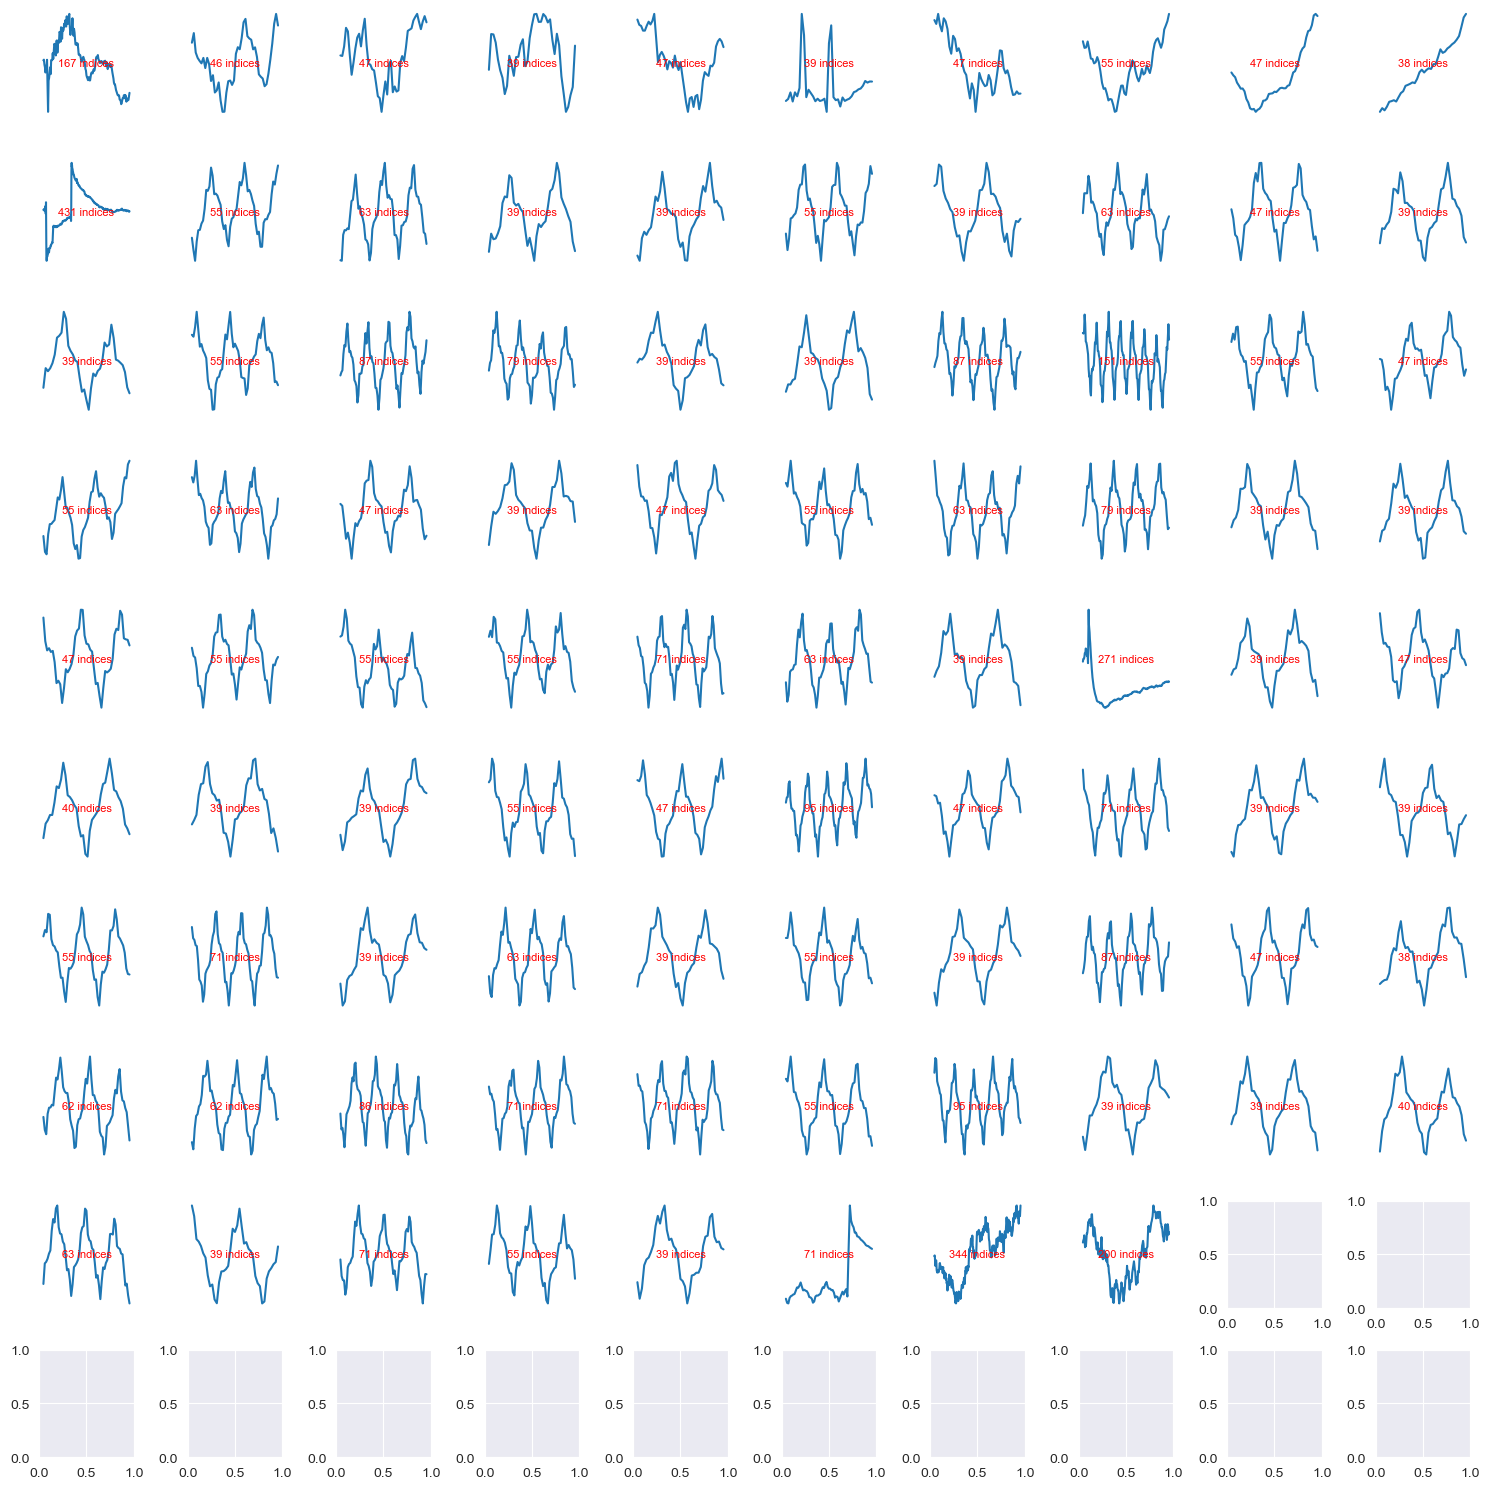

In [28]:
def plot_ripples_grid(lfp_data, ripples, num_ripples=100):
    # Assuming the ripples data has been converted to int already
    fig, axes = plt.subplots(10, 10, figsize=(15, 15))

    count = 0
    for ripple in ripples:
        if count >= num_ripples:
            break

        start, stop = ripple
        duration = stop - start

        # If duration is less than 38, skip plot
        if duration < 38:
            continue

        row = count // 10
        col = count % 10

        axes[row, col].plot(lfp_data[start:stop, 4]) 
        axes[row, col].axis('off')
        
        axes[row, col].text(0.5, 0.5, f"{duration} indices", 
                            transform=axes[row, col].transAxes, 
                            ha='center', va='center', color='red', fontsize=8)
        
        count += 1

    plt.tight_layout()
    plt.show()

plot_ripples_grid(data, cnn_ripples)

In [70]:
#@markdown This is an interactive plot of the loaded data, where detected ripples are shown in blue. Data is displayed in chunks of 1 seconds and you can **move forward, backwards or jump to an specific second** using the control bar at the bottom.\
#@markdown \
#@markdown Run this cell to load the plotting method. Execute the **following** cell to use the method.
%matplotlib notebook
from matplotlib.widgets import Slider
downsampled_fs = 1250


def plot_ripples(k):
    data_size = data.shape[0]
    data_dur = data_size / downsampled_fs
    times = np.arange(data_size) / downsampled_fs

    if k >= times[-1]:
        print("Data is only %ds long!"%(times[-1]))
        return
    elif k < 0:
        print("Please introduce a valid integer.")
        return

    ini_idx = int(k * downsampled_fs)
    end_idx = np.minimum(int((k+1) * downsampled_fs), data_size-1)


    pos_mat = list(range(data.shape[1]-1, -1, -1)) * np.ones((end_idx-ini_idx, data.shape[1]))

    fig = plt.figure(figsize=(9.75,5))
    ax = fig.add_subplot(1,1,1)
    ax.set_ylim(-3,9)
    ax.margins(x=0)
    plt.tight_layout()

    plt.subplots_adjust(bottom=0.25)
    ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])
    slider = Slider(ax_slider, 'Time (s)', 0, times[-1]-1, valinit=k)

    lines = ax.plot(times[ini_idx:end_idx], data[ini_idx:end_idx, :]*1/np.max(data[ini_idx:end_idx, :], axis=0) + pos_mat, color='k', linewidth=1)
    fills = []
    for pred in pred_indexes:
      if (pred[0] >= ini_idx and pred[0] <= end_idx) or (pred[1] >= ini_idx and pred[1] <= end_idx):
          rip_ini = (pred[0]) / downsampled_fs
          rip_end = (pred[1]) / downsampled_fs
          fill = ax.fill_between([rip_ini, rip_end], [-3, -3], [9, 9], color="tab:blue", alpha=0.3)
          fills.append(fill)



    def update(val):
        k = int(slider.val)
        ax.clear()

        ini_idx = int(k * downsampled_fs)
        end_idx = np.minimum(int((k+1) * downsampled_fs), data_size-1)
        pos_mat = list(range(data.shape[1]-1, -1, -1)) * np.ones((end_idx-ini_idx, data.shape[1]))

        ax.set_ylim(-3, 9)
        ax.margins(x=0)
        ax.set_xlabel("Time (s)")


        lines = ax.plot(times[ini_idx:end_idx], data[ini_idx:end_idx, :]*1/np.max(data[ini_idx:end_idx, :], axis=0) + pos_mat, color='k', linewidth=1)
        fills = []
        for pred in pred_indexes:
          if (pred[0] >= ini_idx and pred[0] <= end_idx) or (pred[1] >= ini_idx and pred[1] <= end_idx):
              rip_ini = (pred[0]) / downsampled_fs
              rip_end = (pred[1]) / downsampled_fs
              fill = ax.fill_between([rip_ini, rip_end], [-3, -3], [9, 9], color="tab:blue", alpha=0.3)
              fills.append(fill)

    slider.on_changed(update)
    update(k)  # Call update once to draw the initial plot

    plt.show()

print("Loaded!")



Loaded!


In [72]:
plot_ripples(k=450)

<IPython.core.display.Javascript object>

In [65]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(32, 0, -1))
shank.set_disconnected_channels([15])
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

<IPython.core.display.Javascript object>

D:\Data\RippleDetection\20230309Recall1\Django_recall1_denoised.probegroup.npy saved


In [66]:
# NRK - this does not seem to be doing a good job - too few ripples!
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = None  # Set to None for automatic detection
thresh = (3, None)  # conservative but good
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)
ripple_epochs

Selected channels for ripples: [11.0]
160 epochs remaining with durations within (0.05,0.45)


160 epochs
Snippet: 
      start     stop  peak_time  peak_power label
0  11.3136  11.4768    11.3904    5.428924      
1  17.6344  17.8200    17.7912    6.495123      
2  22.2808  22.3328    22.3096    3.514030      
3  25.2864  25.3384    25.3120    3.891945      
4  39.1344  39.2072    39.1608    7.125543      

In [86]:
ripple_epochs.source_file = sess.filePrefix.with_suffix(".ripple.npy")
ripple_epochs.save(ripple_epochs.source_file)  # save to .npy file
sess.recinfo.write_epochs(epochs=ripple_epochs, ext='swr')  # save for neuroscope event file

D:\Data\RippleDetection\20230309Recall1\Django_recall1_denoised.ripple.npy saved


In [85]:
# Pull ripples from file
thresholded_neuropy_ripples_file = np.load('D:\\Data\\RippleDetection\\20230309Recall1\\Django_recall1_denoised.ripple.npy', allow_pickle=True)

data_dict = thresholded_neuropy_ripples_file.item()
start_times = data_dict['epochs']['start']
stop_times = data_dict['epochs']['stop']
ripple_times = np.column_stack((start_times, stop_times))


assert start_times.keys() == stop_times.keys()
neuropy_ripples = [[start_times[key], stop_times[key]] for key in start_times]
test = (np.array(neuropy_ripples) * 1250).astype(int)

plot_ripples_grid(data, test)

<IPython.core.display.Javascript object>

In [79]:
def overlap_intervals(a, b):
    # Tag intervals from 'a' with 0 and from 'b' with 1
    tagged_a = [(start, end, 0) for start, end in a]
    tagged_b = [(start, end, 1) for start, end in b]
    
    # Merge and sort all intervals by start time
    intervals = tagged_a + tagged_b
    intervals.sort(key=lambda x: x[0])
    
    overlapping = []
    stack = []
    
    for start, end, tag in intervals:
        while stack and stack[-1][1] < start:
            stack.pop()
            
        for _, prev_end, _ in stack:
            if prev_end > start:
                overlapping.append((start, min(prev_end, end)))
        
        stack.append((start, end, tag))
                
    return overlapping

def non_overlap_intervals(a, b):
    # Tag intervals from 'a' with 0 and from 'b' with 1
    tagged_a = [(start, end, 0) for start, end in a]
    tagged_b = [(start, end, 1) for start, end in b]
    
    # Merge and sort all intervals by start time
    intervals = tagged_a + tagged_b
    intervals.sort(key=lambda x: x[0])
    
    non_overlapping = []
    curr_end = None
    curr_tag = None
    
    for start, end, tag in intervals:
        if curr_end is None:
            curr_end = end
            curr_tag = tag
        else:
            if start <= curr_end:
                curr_end = max(curr_end, end)
                curr_tag = -1  # overlapping region from both 'a' and 'b'
            else:
                if curr_tag != -1:
                    non_overlapping.append((curr_end, start, curr_tag))
                curr_end = end
                curr_tag = tag
                
    return non_overlapping
print(overlap_intervals(cnn_ripples, neuropy_ripples))
np.shape(overlap_intervals(cnn_ripples, neuropy_ripples))

[(11.3536, 11.3656), (11.36, 11.372), (11.36, 11.3656), (15.8208, 15.8264), (18.8416, 18.8472), (56.3584, 56.364), (56.448, 56.4536), (56.4672, 56.4728), (57.088, 57.0936), (57.0944, 57.1), (60.7296, 60.7352), (63.2256, 63.2312), (63.328, 63.3336), (65.1008, 65.1064), (65.4336, 65.4392), (65.7088, 65.7144), (65.7152, 65.7208), (65.7216, 65.7272), (112.6976, 112.7032), (116.1408, 116.1464), (116.2368, 116.2424), (116.2624, 116.268), (116.2816, 116.2872), (119.7824, 119.788), (121.9072, 121.9128), (121.9136, 121.9192), (121.9584, 121.964), (121.9648, 121.9704), (121.9712, 121.9768), (129.2608, 129.2664), (129.3888, 129.3944), (129.3952, 129.4008), (157.4208, 157.4264), (185.76, 185.7656), (205.1328, 205.1384), (228.2688, 228.2744), (234.8032, 234.8088), (234.8224, 234.828), (266.0416, 266.0472), (266.048, 266.0536), (310.752, 310.7576), (343.5264, 343.532), (355.6096, 355.6152), (380.9664, 380.972), (404.9664, 404.972), (431.84, 431.8456), (445.8496, 445.8552), (462.528, 462.5336), (479.

(470, 2)

In [80]:
print(non_overlap_intervals(cnn_ripples, neuropy_ripples))
np.shape(non_overlap_intervals(cnn_ripples, neuropy_ripples))

[(11.2184, 11.3136, 0), (13.3688, 15.8144, 0), (15.852, 15.872, 0), (15.884, 17.6344, 0), (17.82, 18.8352, 1), (19.6984, 22.2808, 0), (22.3328, 25.2864, 1), (25.3384, 32.4288, 1), (32.4408, 33.4016, 0), (33.4136, 39.1344, 0), (39.2072, 53.6384, 1), (53.6504, 54.1952, 0), (54.2072, 54.2144, 0), (54.2264, 56.2368, 0), (56.2488, 56.3136, 0), (56.3256, 56.3392, 0), (56.3512, 56.352, 0), (56.3832, 56.4416, 0), (56.4984, 57.0816, 0), (58.7384, 58.816, 0), (58.828, 58.848, 0), (58.86, 58.8736, 0), (58.8856, 58.8928, 0), (58.9048, 58.9504, 0), (58.9624, 58.9952, 0), (59.0072, 60.7232, 0), (62.716, 63.1552, 1), (63.1672, 63.1808, 0), (63.1928, 63.1936, 0), (63.2056, 63.2192, 0), (63.2504, 63.3216, 0), (63.3528, 64.544, 0), (64.556, 64.5568, 0), (64.5688, 65.0944, 0), (65.2856, 65.408, 0), (65.42, 65.4272, 0), (65.548, 65.5552, 0), (65.5672, 65.6832, 0), (65.6952, 65.7024, 0), (72.044, 80.6272, 0), (80.6392, 82.6176, 0), (82.6296, 82.7328, 0), (82.7448, 87.9744, 0), (87.9864, 95.5648, 0), (95.57

(670, 3)